In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from tqdm import tqdm
import pickle as pkl

from testbed.models.ngboost import NGBoostGaussian, NGBoostMixtureGaussian
from testbed.models.treeffuser import Treeffuser

from functools import partial

from jaxtyping import Float, Array
from typing import List, Callable

import seaborn as sns
import matplotlib.pyplot as plt
from testbed.metrics.log_likelihood import LogLikelihoodFromSamplesMetric

path = "../src/testbed/data/m5"

# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
# These are config variables

PROCESS_FROM_SCRATCH = True
USE_SUBSET = True
CONTEXT_LENGTH = 20
RUN_DEPRECATED = False

In [3]:
# READ IN DATA

sell_prices_df = pd.read_csv(Path(path) / "sell_prices.csv")
sales_train_validation_df = pd.read_csv(Path(path) / "sales_train_validation.csv")
calendar_df = pd.read_csv(Path(path) / "calendar.csv")

print("\ncolumns of sell_prices_df:")
[print(col) for col in sell_prices_df.columns]
print("\ncolumns of sales_train_validation_df:")
[print(col) for col in sales_train_validation_df.columns if not col.startswith("d_")]
print("\ncolumns of calendar_df:") # ommit d_1, d_2, ..., d_1913
[print(col) for col in calendar_df.columns if not col.startswith("d_")]

""




columns of sell_prices_df:
store_id
item_id
wm_yr_wk
sell_price

columns of sales_train_validation_df:
id
item_id
dept_id
cat_id
store_id
state_id

columns of calendar_df:
date
wm_yr_wk
weekday
wday
month
year
d
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI


''

In [4]:
# add explicit columns for the day, month, year for ease of processing
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["day"] = calendar_df["date"].dt.day
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["year"] = calendar_df["date"].dt.year


# Brief snapshots of the dataset

In [5]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2


In [6]:
sales_train_validation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Process the data

In [8]:
TOTAL_ITEMS = 10_000
# select a random subset of items
if USE_SUBSET:
    np.random.seed(0)
    unique_ids = sales_train_validation_df["id"].unique()
    ids = np.random.choice(sales_train_validation_df["id"].unique(), TOTAL_ITEMS, replace=False)
    sales_train_validation_df_sub = sales_train_validation_df[sales_train_validation_df["id"].isin(ids)]
    item_ids = sales_train_validation_df_sub["item_id"].unique()
    sell_prices_df_sub = sell_prices_df[sell_prices_df["item_id"].isin(item_ids)]
    calendar_df_sub = calendar_df





columns_sales_train_validation.head)

The strategy for processing the data is going to be the following. 1) We are going to have X and y where y is the next days sales for a given product. 3) X is made up of 10 previous prices, day of the week, + event types, cat_id, store_id, state_id

In [9]:
def proc_train_test(sales_train_validation_df: pd.DataFrame, calendar_df: pd.DataFrame, sell_prices_df: pd.DataFrame, context_length: int, test_percentage: float, percentage_omittied: int = 0): #type annotation too long
    """
    This function processes the data and returns the training and test data in two ways:
    - undifferentiated: a list of all training and test data (X_train, y_train, X_test, y_test)
    - differentiated: a list of training and test data for each product (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
        where X_train_prod[i] contains a list of all X_train values for the product i with similar grouping for y_train_prod and test

    This assumes from the dataframes that
    - sales_train_validation_df:
        - has columns with the format d_1, d_2, ...
        - has columns item_id and store_id
    - calendar_df:
        - wday, month, event_name_1, event_name_2
    - sell_prices_df:
        - item_id, store_id, sell_price

    - percentage_omittied: percentage of the data to be omitted from the training data and the test data
        (randomly selected)

    Returns:
    - undifferentiated: Tuple of X_train, y_train, X_test, y_test
    - differentiated: Tuple of X_train_prod, y_train_prod, X_test_prod, y_test_prod
    """
    np.random.seed(0)
    # First we need to get the training data
    # We will use the first 1913 days as training data and the next

    X_train = []
    y_train = []

    X_test = []
    y_test = []

    # We will also return a second grouping of lists where X_train_prod[i] contains a
    # a list of all X_train values for the product i with similar grouping for y_train_prod and test
    X_train_prod = []
    y_train_prod = []
    X_test_prod = []
    y_test_prod = []


    # get all days that start with d_ and look for the maximum
    total_days = max([int(x.split("_")[1]) for x in sales_train_validation_df.columns if "d_" in x])
    train_days = int(total_days * (1 - test_percentage))

    # Precompute the required data
    calendar_df_dict = calendar_df.set_index("d").to_dict(orient="index")
    sell_prices_dict = sell_prices_df.groupby(["item_id", "store_id"])["sell_price"].first().to_dict()

    pbar = tqdm(total=len(sales_train_validation_df))
    for _, row in sales_train_validation_df.iterrows():
        item_id = row["item_id"]
        store_id = row["store_id"]

        X_train_prod.append([])
        y_train_prod.append([])
        X_test_prod.append([])
        y_test_prod.append([])

        pbar.update(1)

        valid_size = int((total_days - context_length) * (1 - percentage_omittied))
        valid_js = np.random.choice(range(1, total_days - context_length), valid_size, replace=False)

        for j in valid_js:
            x = []

            # Add sales values for the previous context_length days
            x.extend(row[f"d_{j+k}"] for k in range(context_length))

            # Add additional features
            current_day = f"d_{j+context_length}"
            calendar_data = calendar_df_dict[current_day]
            x.extend([
                calendar_data["wday"],
                calendar_data["month"],
                store_id,
                calendar_data["event_name_1"],
                calendar_data["event_name_2"],
                sell_prices_dict[(item_id, store_id)],
                item_id
            ])

            if j < train_days:
                X_train.append(x)
                y_train.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

            else:
                X_test.append(x)
                y_test.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

    undifferentiated = (X_train, y_train, X_test, y_test)
    differentiated = (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
    return undifferentiated, differentiated

In [10]:
if PROCESS_FROM_SCRATCH:
    undifferentiated, differentiated = proc_train_test(sales_train_validation_df_sub, calendar_df, sell_prices_df_sub, CONTEXT_LENGTH, 0.1, 0.99)
    X_train, y_train, X_test, y_test = undifferentiated
    X_train_prod, y_train_prod, X_test_prod, y_test_prod = differentiated


100%|██████████| 10000/10000 [00:12<00:00, 827.49it/s]


In [11]:
len(X_train), len(y_train), len(X_test), len(y_test)

(163642, 163642, 16358, 16358)

In [12]:
COL_NAMES = [
    f"day_{i}" for i in range(1, CONTEXT_LENGTH+1)
] + ["wday", "month", "store_id", "event_name_1", "event_name_2", "sell_price", "item_id"]

CAT_COLS = ["store_id", "event_name_1", "event_name_2", "item_id", "wday", "month"]
CAT_COLS_IDX = [COL_NAMES.index(col) for col in CAT_COLS]


In [13]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

X_train_df.columns = COL_NAMES
X_test_df.columns = COL_NAMES

In [14]:

X_train_df

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_18,day_19,day_20,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id
0,0,2,3,2,1,4,0,1,0,1,...,0,0,0,2,12,CA_1,NaN,NaN,2.98,HOBBIES_1_005
1,3,2,8,0,0,0,0,0,0,0,...,5,0,3,4,1,CA_1,NaN,NaN,2.98,HOBBIES_1_005
2,2,1,0,1,1,2,0,1,4,2,...,2,0,2,1,3,CA_1,NaN,NaN,2.98,HOBBIES_1_005
3,0,0,3,1,0,0,2,3,1,0,...,2,1,3,1,12,CA_1,NaN,NaN,2.98,HOBBIES_1_005
4,2,2,0,1,1,4,0,0,0,1,...,2,1,0,3,6,CA_1,NaN,NaN,2.98,HOBBIES_1_005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,7,7,WI_3,NaN,NaN,1.00,FOODS_3_827
163638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,11,WI_3,NaN,NaN,1.00,FOODS_3_827
163639,0,0,1,0,3,5,4,2,1,2,...,2,0,4,1,2,WI_3,ValentinesDay,NaN,1.00,FOODS_3_827
163640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,WI_3,NaN,NaN,1.00,FOODS_3_827


In [15]:
# Encode the categorical columns as numbers
from sklearn.preprocessing import LabelEncoder
# Get only label of item_id
X_train_df["item_id"] = X_train_df["item_id"].apply(lambda x: x.split("_")[1])
X_test_df["item_id"] = X_test_df["item_id"].apply(lambda x: x.split("_")[1])


label_encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])
    X_test_df[col] = le.transform(X_test_df[col])
    label_encoders[col] = le


X_train_prod_processed = []
X_test_prod_processed = []
for i in range(len(X_train_prod)):
    X_train_prod_processed.append(pd.DataFrame(X_train_prod[i], columns=COL_NAMES))
    X_test_prod_processed.append(pd.DataFrame(X_test_prod[i], columns=COL_NAMES))
    X_train_prod_processed[-1]["item_id"] = X_train_prod_processed[-1]["item_id"].apply(lambda x: x.split("_")[1])
    X_test_prod_processed[-1]["item_id"] = X_test_prod_processed[-1]["item_id"].apply(lambda x: x.split("_")[1])
    for col in CAT_COLS:
        X_train_prod_processed[-1][col] = label_encoders[col].transform(X_train_prod_processed[-1][col])
        X_test_prod_processed[-1][col] = label_encoders[col].transform(X_test_prod_processed[-1][col])

X_train_df.head()


,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_18,day_19,day_20,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id
0,0,2,3,2,1,4,0,1,0,1,...,0,0,0,1,11,0,30,4,2.98,0
1,3,2,8,0,0,0,0,0,0,0,...,5,0,3,3,0,0,30,4,2.98,0
2,2,1,0,1,1,2,0,1,4,2,...,2,0,2,0,2,0,30,4,2.98,0
3,0,0,3,1,0,0,2,3,1,0,...,2,1,3,0,11,0,30,4,2.98,0
4,2,2,0,1,1,4,0,0,0,1,...,2,1,0,2,5,0,30,4,2.98,0


# PPC

### "Standard PPCs"

In [16]:

def max_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    max_ppc = np.max(y_samples, axis=1)
    true_max = np.max(y_true)

    return max_ppc.flatten(), true_max.flatten(), "max_ppc"

def quantile_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], quantile=0.5, number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    q = np.quantile(y_samples, quantile, axis=1)
    true_q = np.quantile(y_true, quantile)
    return q.flatten(), true_q.flatten(), f"quantile_ppc_{quantile}"

def zeros(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    "Count the number of zeros in the samples"
    zeros = np.sum(y_samples < 0.1, axis=1)
    true_zeros = np.sum(y_true < 0.1)

    return zeros.flatten(), true_zeros.flatten(), "zeros"

In [17]:
def plot_ppcs(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], ppcs: List[Callable],
              number=0, name="") -> None:
    # plot the distribution of

    for ppc in ppcs:
        ppc(y_true, y_samples, number=number, name=name)

### "Complex PPCs"

In [18]:

def plot_model_comparisons(data, y_true, figsize=(12, 8), model_names=None):
    """
    Plots model predictions against true values for each day.

    :param data: numpy array of shape [models, samples, days] containing model predictions
    :param y_true: array of shape [days] containing the true values
    :param figsize: tuple indicating the size of the figure
    """
    sns.set(style="whitegrid")
    models, samples, days = data.shape

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=figsize)

    # We will transform the data to a format suitable for seaborn
    # Create a DataFrame with model, day, and sample values
    plot_data = []
    if model_names is None:
        model_names = [f"Model {i}" for i in range(models)]

    for model_idx in range(models):
        for day_idx in range(days):
            for sample_idx in range(samples):
                plot_data.append({
                    "Day": day_idx,
                    "Value": data[model_idx, sample_idx, day_idx],
                    "Model": model_names[model_idx]
                })

    import pandas as pd
    plot_data = pd.DataFrame(plot_data)

    # Use seaborn to plot the boxplots
    sns.boxplot(x="Day", y="Value", hue="Model", data=plot_data, ax=ax, width=0.6)

    # Plot true values
    plt.plot(y_true, 'o', color='red', label='True Values')

    # Setting labels and title
    plt.xticks(ticks=np.arange(days), labels=[f"Day {i+1}" for i in range(days)])
    plt.xlabel('Days')
    plt.ylabel('Values')
    plt.title('Model Predictions vs. True Values')
    plt.legend()

    # Show the plot
    plt.show()







# Model Evaluation

In [19]:
# Simple helper function to train a model and plot ppcs

def get_ppcs(y_samples, X_test, y_test, ppcs, number=0, name="") -> None:
    """
    Returns a dictionary with the samples and the true values for each ppc
    the dictionary a
    """

    ppc_results = {}
    for ppc in ppcs:
        samples, true, name = ppc(y_test, y_samples, number=number, name=name)
        ppc_results[name] = {"samples": samples, "true": true}

    return ppc_results


In [20]:
print(X_train_df.head())

   day_1  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  day_10  ...  \
0      0      2      3      2      1      4      0      1      0       1  ...   
1      3      2      8      0      0      0      0      0      0       0  ...   
2      2      1      0      1      1      2      0      1      4       2  ...   
3      0      0      3      1      0      0      2      3      1       0  ...   
4      2      2      0      1      1      4      0      0      0       1  ...   

   day_18  day_19  day_20  wday  month  store_id  event_name_1  event_name_2  \
0       0       0       0     1     11         0            30             4   
1       5       0       3     3      0         0            30             4   
2       2       0       2     0      2         0            30             4   
3       2       1       3     0     11         0            30             4   
4       2       1       0     2      5         0            30             4   

   sell_price  item_id  
0      

In [21]:
EVAL_VALUES = 10_000 # How many test points to use
np.random.seed(0)

eval_idx = np.random.choice(len(X_test_df), EVAL_VALUES, replace=False)

X_train_np = X_train_df.values
X_test_np = X_test_df.values[eval_idx]

y_train_np = y_train_df.values #+ np.random.normal(0, 0.1, y_train_df.shape)
y_test_np = y_test_df.values[eval_idx]

# change to float to prevent errors
y_train_np = y_train_np.astype(np.float32)
y_test_np = y_test_np.astype(np.float32)


In [58]:
MODEL_CLASSES = [Treeffuser]#, NGBoostGaussian]
NUM_SAMPLES = 200
HYPERS = [
    {"subsample": 0.30, "subsample_freq": 1, "verbose": 2, "num_leaves":128, "learning_rate":1, "sde_manual_hyperparams":
        {
            "hyperparam_max": 10,
        }
    },
    {},

]

results = []
for i in range(len(MODEL_CLASSES)):
    model_cls = MODEL_CLASSES[i]
    model = model_cls(**HYPERS[i])
    model.fit(X_train_np, y_train_np)

    y_samples = model.sample(X_test_np, n_samples=NUM_SAMPLES)
    res = {
        "y_samples": y_samples,
        "y_true": y_test_np,
        "model": model,
        "model_name": model_cls.__name__
    }
    results.append(res)

0.3
1
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.958850
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.066128
[LightGBM] [Debug] init for col-wise cost 0.059197 seconds, init for row-wise cost 0.601062 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 8182100, number of used features: 29
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score -0.000063
[LightGBM] [Debug] Re-bagging, using 2456713 data to train
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 15
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug] Re-bagging, using 2454591 data to t

100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


Now we can actually fit some of the models

In [60]:
ppcs = [max_ppc, zeros] + [partial(quantile_ppc, quantile=q) for q in [0.1, 0.5, 0.9, 0.99]]

for i, model_cls in enumerate(MODEL_CLASSES):
    ppc_results = get_ppcs(
        y_samples=results[i]["y_samples"],
        X_test=X_test_np,
        y_test=y_test_np,
        ppcs=ppcs,
        number=i,
        name=model_cls.__name__
    )
    results[i]["ppc_results"] = ppc_results


# Plot the PPCs

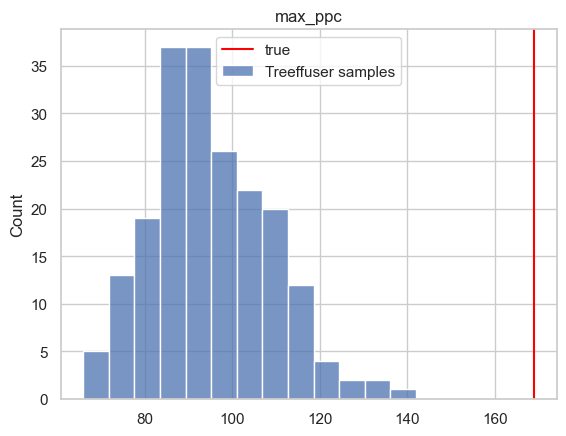

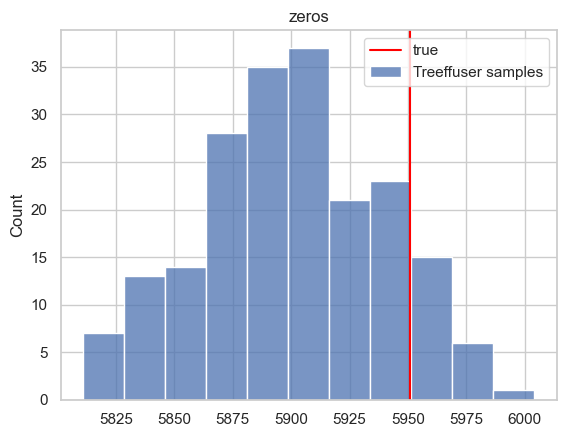

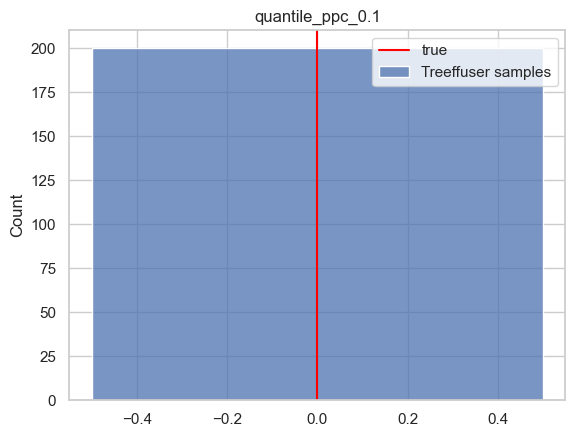

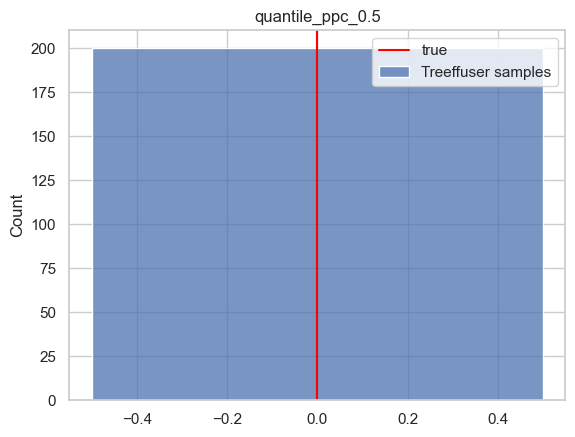

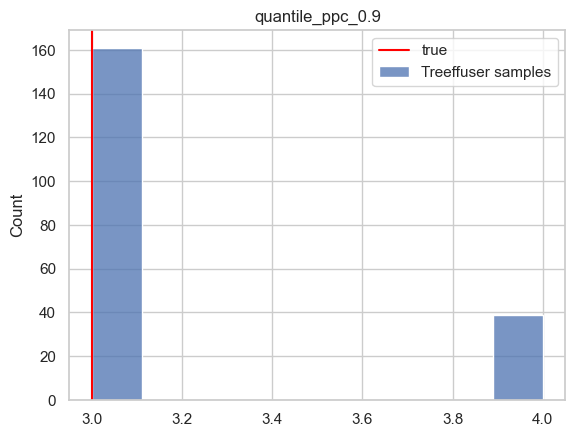

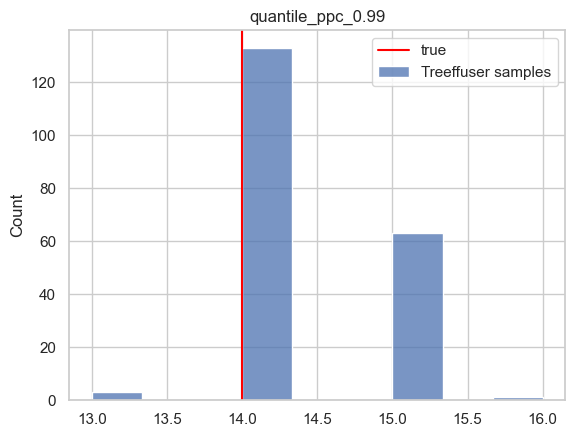

In [61]:
ppc_number = len(ppcs)
ppc_names = results[0]["ppc_results"].keys()

for ppc_name in ppc_names:
    fig, ax = plt.subplots()
    for i, res in enumerate(results):
        model_name = res["model_name"]
        samples = res["ppc_results"][ppc_name]["samples"]
        # make int
        #samples = np.max(samples, 0)
        samples =  np.round(samples)
        true = res["ppc_results"][ppc_name]["true"]

        # plot a histogram of the samples
        sns.histplot(samples, ax=ax, label=f"{model_name} samples")
        ax.axvline(true, color="red", label="true")
        ax.set_title(f"{ppc_name}")
        ax.legend()




In [62]:
np.random.seed(0)

NUM_PRODS_TO_PLOT = 5
DAYS_TO_PLOT = 10
QUATILE = 0.9
NUM_SAMPLES = 100

prods_to_plot = np.random.choice(range(len(X_train_prod_processed)), NUM_PRODS_TO_PLOT)

means_to_plot = []
lower_q_s = []
upper_q_s = []

prod_dict = {}

for res in results:
    model = res["model"]

    for i in prods_to_plot:
        if i not in prod_dict:
            prod_dict[i] = {
                "means_to_plot": [],
                "lower_q_s": [],
                "upper_q_s": [],
                "samples": []
            }

        X_prod_proc_i = X_train_prod_processed[i][-DAYS_TO_PLOT:]
        y_prod_proc_i = y_train_prod[i][-DAYS_TO_PLOT:]

        samples = model.sample(X_prod_proc_i.values, NUM_SAMPLES)
        samples = samples.astype(int)
        samples = np.maximum(samples, 0)

        means = np.mean(samples, axis=0)
        lower_q = np.quantile(samples, 1-QUATILE, axis=0)
        upper_q = np.quantile(samples, QUATILE, axis=0)

        prod_dict[i]["means_to_plot"].append(means)
        prod_dict[i]["lower_q_s"].append(lower_q)
        prod_dict[i]["upper_q_s"].append(upper_q)
        prod_dict[i]["samples"].append(samples)

for i in prod_dict:
    means_to_plot = np.array(prod_dict[i]["means_to_plot"]).squeeze()
    lower_q_s = np.array(prod_dict[i]["lower_q_s"]).squeeze()
    upper_q_s = np.array(prod_dict[i]["upper_q_s"]).squeeze()
    samples = np.array(prod_dict[i]["samples"]).squeeze()
    y_true = np.array(y_train_prod[i][-DAYS_TO_PLOT:])

    model_names = [res["model"].__class__.__name__ for res in results]

    print("mean shape", means_to_plot.shape)
    print("lower shape", lower_q_s.shape)
    print("upper shape", upper_q_s.shape)
    print("y_true shape", y_true.shape)
    print("samples shape", samples.shape)

    #plot_predictions(y_true, means_to_plot, upper_q_s, lower_q_s, [res["model"].__class__.__name__ for res in results])
    plot_model_comparisons(samples, y_true, model_names=model_names)


100%|██████████| 100/100 [00:00<00:00, 104.19it/s]

mean shape (10,)
lower shape (10,)
upper shape (10,)
y_true shape (10,)
samples shape (100, 10)


ValueError: not enough values to unpack (expected 3, got 2)

# Log-likelihood

In [63]:
for res in results:
    model = res["model"]
    nll = LogLikelihoodFromSamplesMetric(n_samples=100).compute(model=model, X_test=X_test_np, y_test=y_test_np, samples=res["y_samples"])
    print(f"Model {model.__class__.__name__} has a NLL of {nll}")

Model Treeffuser has a NLL of {'nll': 11746.119428108415}


# Plot calibration plot

In [64]:
def calibration_plot(y_samples: Float[np.ndarray, "n_samples batch y_dim"], y_test: Float[np.ndarray, "batch y_dim"]) -> None:
    """
    We will plot the calibration plot for the model. Essentially, we will plot the
    """
    assert y_test.shape[1] == 1, "Only works for univariate outputs"
    n_samples = y_samples.shape[0]

    y_test_expanded = y_test[np.newaxis, :].repeat(n_samples, axis=0)
    less_than = np.mean(y_test_expanded < samples, axis=0)
    less_than = less_than.flatten().astype(np.float32)
    sorted_less_than = np.sort(less_than)
    return sorted_less_than, np.arange(len(sorted_less_than)) / len(sorted_less_than)




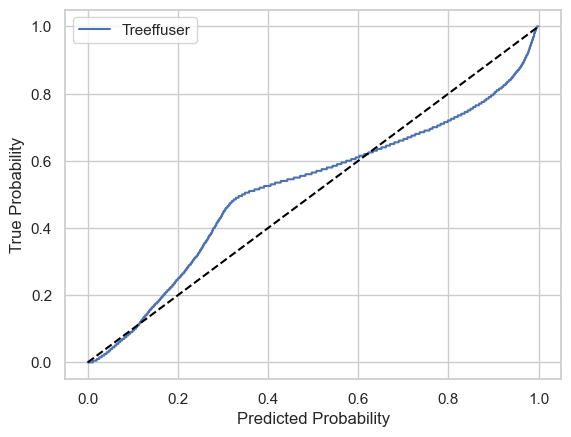

In [65]:
for res in results:
    samples = res["y_samples"]
    model = res["model"]
    less_than, x = calibration_plot(y_samples, y_test_np)
    plt.plot(x, less_than, label=model.__class__.__name__)


plt.plot([0, 1], [0, 1], linestyle="--", color="black")

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()